pre-processing

In [2]:
data_df = pd.read_csv('Data\\processed.csv')

In [3]:
def get_high_cor(data, threshold = 0.2):
    cor = data.corr().stack().reset_index().drop_duplicates()
    cor.columns = ['FEATURE_1', 'FEATURE_2', 'CORRELATION']
    high_cor = cor[((cor['FEATURE_1'] != cor['FEATURE_2'] ) & ((cor['CORRELATION'] >= threshold) | (cor['CORRELATION'] <= threshold * -1)))]
    return high_cor

In [4]:
high_cor = get_high_cor(data_df)
cor = high_cor[((high_cor['FEATURE_1'] == 'KWH'))]

In [5]:
cor

,FEATURE_1,FEATURE_2,CORRELATION
713233,KWH,TYPEHUQ,-0.352917
713236,KWH,CDD65,0.245610
713238,KWH,CDD30YR,0.256357
713240,KWH,AIA_Zone,0.200681
713242,KWH,UR,0.260477
...,...,...,...
714101,KWH,TOTALDOLWTH,0.437861
714102,KWH,TOTALDOLRFG,0.433450
714103,KWH,TOTALDOLOTH,0.655677
714107,KWH,KAVALNG,-0.275771


In [6]:
corr_list = []

for elem in cor['FEATURE_2']:
    corr_list.append(elem)

high_cor_df = data_df[data_df.columns.intersection(corr_list)]

data_df = pd.concat((high_cor_df, data_df['KWH']),axis = 1)

print(data_df)
# high_cor_df.to_csv("./Data/high_cor_df.csv", index=False)

       TYPEHUQ  CDD65  CDD30YR  AIA_Zone  UR  KOWNRENT  YEARMADE  \
0            2   1080     1271         3   0         1      2004   
1            2    199      143         4   0         2      1998   
2            5    505      829         2   0         2      1965   
3            2    672      868         2   0         1      1985   
4            3    702      797         3   0         1      1983   
...        ...    ...      ...       ...  ..       ...       ...   
12076        2    332      451         1   0         1      1985   
12077        4   2844     2286         5   0         2      1980   
12078        2    472      600         1   0         1      1993   
12079        2    770      957         2   0         1      1930   
12080        2    124      139         4   0         1      1948   

       YEARMADERANGE  NUMFLRS  ROOFTYPE  ...  TOTALBTURFG  TOTALBTUOTH  \
0                  7        0         5  ...         5171        26363   
1                  6        0      

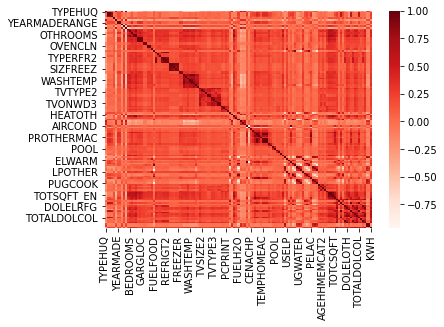

In [7]:
cor = data_df.corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.show()

In [8]:
X = data_df[data_df.columns.difference(['KWH'])]
Y = data_df['KWH']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle = True, random_state = 42)

In [9]:
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
rr = Ridge(
    random_state=42,
    solver = 'auto'

)
rf = RandomForestRegressor(
    oob_score = True, 
    random_state = 42,
)
sgd = SGDRegressor( 
    random_state=42,
    penalty='l1', 
)
ls = Lasso(
    random_state = 42 
)
estimators = [rr, rf, sgd, ls]

In [ ]:
param_rr = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]} 
param_rf = {'n_estimators': [5, 50, 100, 200, 500], 'max_depth': [1, 5, 10, 15], 'min_samples_leaf': [1, 5, 10]}
param_sgd = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'loss': ['squared_epsilon_insensitive', 'huber'], 'learning_rate': ['optimal', 'adaptive']}
param_ls = {"selection":["cyclic", "random"], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
 
 
params = [param_rr, param_rf, param_sgd, param_ls]

In [ ]:
def performingGridSearch(estimators, X_train, Y_train, X_test, Y_test, params):
  scores_train = []
  scores_test = []
 
  for index, estimator in enumerate(estimators):
    model = GridSearchCV(estimator, param_grid = params[index], cv = 3, n_jobs=-1, scoring='r2', verbose = 3)
    model.fit(X_train, Y_train)
    best_params = model.best_params_
    scores_train.append(model.score(X_train, Y_train))
 
    print("\n\n Model: {} \n\n Best params: {} ".format(estimator, best_params))
    scores_test.append(model.score(X_test, Y_test))
    
    
    
  return scores_train, scores_test

In [ ]:
scores_train, scores_val = performingGridSearch(estimators, X_train, Y_train, X_test, Y_test, params)

models implementation

In [10]:
reg = LinearRegression().fit(X_train, Y_train)
print(reg.score(X_test, Y_test))
print(reg.score(X_train, Y_train))
print("\n\n")


lasso = Lasso(alpha=0.01)
lasso.fit(X_train, Y_train)
print(lasso.score(X_test, Y_test))
print(lasso.score(X_train, Y_train))

0.9776179878149662
0.9751814506648859



0.9777267974235655
0.9752586852923838
C:\Users\Daniel Ciovica\miniconda3\envs\bigdata\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5625984880.639406, tolerance: 51375337.476005666
  model = cd_fast.enet_coordinate_descent(


In [13]:
y_train_pred = reg.predict(X_train)
print("\n\n Train summary: \n\n")
print("\n\n R2 Score: {} ".format(reg.score(X_train, Y_train)))
print("\n\n MAPE Score: {} \n\n".format(mean_absolute_percentage_error(Y_train, y_train_pred)))


y_test_pred = reg.predict(X_test)
print("\n\n Test summary: \n\n")
print("\n\n R2 Test Score: {} ".format(lasso.score(X_test, Y_test)))
print("\n\n MAPE Score: {} ".format(mean_absolute_percentage_error(Y_test, y_test_pred)))



 Train summary: 




 R2 Score: 0.9751814506648859 


 MAPE Score: 0.10455417557029821 




 Test summary: 




 R2 Test Score: 0.9777267974235655 


 MAPE Score: 0.08693569469640998 
